In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch

import os
from src.utils.datasets.voc import VOCDetection
from src.utils.datasets.voc  import VOCMerge

from src.utils.datasets.ggimages import OpenImage
from src.utils.datasets.transform import RandomHorizontalFlip, Resize, Compose, XyToCenter
import torchvision.transforms as transforms
from src.utils.display.images import imshow, result_show
from torch.utils.data import DataLoader
from src.utils.datasets.adapter import convert_data
import numpy as np
from src.network.yolo import Yolo
from src.config import VOC_ANCHORS
from src.utils.process_boxes import preprocess_true_boxes
from src.utils.process_boxes import preprocess_true_boxes
from src.config import IOU_THRESHOLD, TENSORBOARD_PATH
from tensorboardX import SummaryWriter
from datetime import datetime
import time
from torch.optim import SGD, RMSprop, Adam
from torch.optim.lr_scheduler import StepLR
from src.utils.evaluate.metter import AverageMeter

general_transform = Compose([
    Resize((448, 448)),
    RandomHorizontalFlip(0.3),
    XyToCenter()
])


transform = transforms.Compose([
                transforms.RandomChoice([
                    transforms.ColorJitter(hue=.3, saturation=.2),
                    transforms.RandomGrayscale(p=0.3),
                ]),
                transforms.ToTensor()])

In [3]:
root = '/data/data/'
ds = VOCMerge(root, 'train', dataset_name='VOC_SMALL', general_transform=general_transform,  transform=transform)
print(len(ds))

val_ds = VOCMerge(root, 'val', dataset_name='VOC_SMALL', general_transform=general_transform, transform=transform)
print(len(val_ds))

batch_size = 48

train_data_loader = DataLoader(ds, batch_size=batch_size,collate_fn=convert_data, shuffle=False, num_workers=2, drop_last=True)
val_data_loader = DataLoader(val_ds, batch_size=batch_size,collate_fn=convert_data,shuffle=False, num_workers=2, drop_last=True)

870
224


In [4]:
ds.classes

['__background__',
 '38',
 '158',
 '193',
 '82',
 '9',
 '91',
 '43',
 '175691',
 '200',
 '87']

In [5]:
from src.network.base import DarkNet, DarknetBody, YoloBody

model = Yolo(VOC_ANCHORS, ds.classes)
model.cuda()
model.train()

Yolo(
  (yolo_body): DataParallel(
    (module): YoloBody(
      (body_bottom): DarknetBodyBottom(
        (first_layer): Conv2d(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): LeakyReLU(negative_slope=0.1)
        )
        (second_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (third_layer): Conv2d(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): LeakyReLU(negative_slope=0.1)
        )
        (forth_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (fifth_layer): BottleneckBlock(
          (first_layer): Conv2d(
            (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),

In [6]:
pretrained_dict = torch.load('./save_model/model_16.pth')
model_dict = model.state_dict()
del pretrained_dict['yolo_body.module.last_layer.weight']
model_dict.update(pretrained_dict) 
model.load_state_dict(model_dict)

In [7]:
for child in model.children():
    for child_2 in child.children():
        for key, child_3 in enumerate(child_2.children()):
            if key < 7:
                for param in child_3.parameters():
                    param.requires_grad = False

In [8]:
def val(data_val_gen ,model):
    val_loss = AverageMeter()
    with torch.no_grad():
        model.eval()
        for step, blobs in enumerate(data_val_gen):
            batch_tensor, batch_boxes, detectors_mask, matching_true_boxes, im_info, img_name = blobs
            batch_tensor = batch_tensor.to(torch.device('cuda'))
            detectors_mask = detectors_mask.to(torch.device('cuda'))
            matching_true_boxes = matching_true_boxes.to(torch.device('cuda'))
            batch_boxes = batch_boxes.to(torch.device('cuda'))
            output = model(batch_tensor)
            loss = model.loss(output, batch_boxes, detectors_mask, matching_true_boxes)
            val_loss.update(loss.item())
    return val_loss

def train(data_gen, data_val_gen ,model, metters, optimizer, lr_scheduler, tensorboard_writer, current_epoch=0):
    
    steps_per_epoch = len(data_gen) 
    model.train()
    train_loss = metters
    start_time = time.time()

    for step, blobs in enumerate(data_gen):
        batch_tensor, batch_boxes, detectors_mask, matching_true_boxes, im_info, img_name = blobs
        batch_tensor = batch_tensor.to(torch.device('cuda'))
        detectors_mask = detectors_mask.to(torch.device('cuda'))
        matching_true_boxes = matching_true_boxes.to(torch.device('cuda'))
        batch_boxes = batch_boxes.to(torch.device('cuda'))
        output = model(batch_tensor)
        loss = model.loss(output, batch_boxes, detectors_mask, matching_true_boxes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        train_loss.update(loss.item())
        del batch_tensor

        current_step = current_epoch * steps_per_epoch + step
        if step % 100 == 10:
            print("epochs time %s" % (time.time() - start_time))
            start_time = time.time()
            tensorboard_writer.add_scalar("loss", train_loss.avg, (current_epoch * steps_per_epoch) + step)
            log_text = 'epoch: %d : step %d,  loss: %.4f at %s' % (
                current_epoch + 1, step , train_loss.avg, datetime.now().strftime('%m/%d_%H:%M'))
            print(log_text)
            

        if step % 500 == 10:
            print("Validate")
            val_loss = val(data_val_gen, model)
            log_text = 'epoch: %d : step %d,  val_loss: %.4f at %s' % (
                current_epoch + 1, step , val_loss.avg, datetime.now().strftime('%m/%d_%H:%M'))
            print(log_text)
            tensorboard_writer.add_scalar("val_loss", val_loss.avg, (current_epoch * steps_per_epoch) + step)

In [9]:
params = filter(lambda x: x.requires_grad, model.parameters())
optimizer = SGD(params, lr = 0.0001, momentum=0.9)

# optimizer = RMSprop(params, lr=1e-5, momentum=0.9, weight_decay=0.005)
# optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=0.00005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.9)

In [10]:
writer = SummaryWriter("%s/voc/%s_rms_0.005_with_aug" % (TENSORBOARD_PATH , datetime.now().strftime('%m/%d_%H:%M')))
train_loss = AverageMeter()
for i in range(20):
    train(train_data_loader, val_data_loader ,model, train_loss, optimizer, exp_lr_scheduler, writer,i)
    torch.save(model.state_dict(), './save_model/voc_model_%s.pth' % i)

/opt/conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epochs time 6.6920387744903564
epoch: 1 : step 10,  loss: 49.7763 at 04/24_08:44
Validate
epoch: 1 : step 10,  val_loss: 18.2135 at 04/24_08:44
epochs time 5.748908519744873
epoch: 2 : step 10,  loss: 26.8571 at 04/24_08:44
Validate
epoch: 2 : step 10,  val_loss: 7.0122 at 04/24_08:44
epochs time 6.042064666748047
epoch: 3 : step 10,  loss: 19.3442 at 04/24_08:44
Validate
epoch: 3 : step 10,  val_loss: 5.8010 at 04/24_08:44
epochs time 5.983747959136963
epoch: 4 : step 10,  loss: 15.6899 at 04/24_08:45
Validate
epoch: 4 : step 10,  val_loss: 5.2593 at 04/24_08:45
epochs time 6.036623239517212
epoch: 5 : step 10,  loss: 13.5154 at 04/24_08:45
Validate
epoch: 5 : step 10,  val_loss: 4.9053 at 04/24_08:45
epochs time 5.901318073272705
epoch: 6 : step 10,  loss: 12.0353 at 04/24_08:45
Validate
epoch: 6 : step 10,  val_loss: 4.6255 at 04/24_08:45
epochs time 6.0420753955841064
epoch: 7 : step 10,  loss: 10.9584 at 04/24_08:45
Validate
epoch: 7 : step 10,  val_loss: 4.3927 at 04/24_08:45
epo

In [11]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
optimizer = SGD(model.parameters(), lr = 0.0001, momentum=0.9)


writer = SummaryWriter("%s/voc/%s_rms_0.005_with_aug_unfreeze" % (TENSORBOARD_PATH , datetime.now().strftime('%m/%d_%H:%M')))
train_loss = AverageMeter()
for i in range(20):
    train(train_data_loader, val_data_loader ,model, train_loss, optimizer, exp_lr_scheduler, writer,i)
    torch.save(model.state_dict(), './save_model/voc_model_unfreeze_%s.pth' % i)

epochs time 6.877964735031128
epoch: 1 : step 10,  loss: 3.0938 at 04/24_07:51
Validate
epoch: 1 : step 10,  val_loss: 3.0439 at 04/24_07:52
epochs time 77.25247550010681
epoch: 1 : step 110,  loss: 3.4237 at 04/24_07:53
epochs time 6.895017862319946
epoch: 2 : step 10,  loss: 3.1674 at 04/24_07:53
Validate
epoch: 2 : step 10,  val_loss: 2.7705 at 04/24_07:54
epochs time 78.07275056838989
epoch: 2 : step 110,  loss: 3.2017 at 04/24_07:55
epochs time 6.969442844390869
epoch: 3 : step 10,  loss: 3.1074 at 04/24_07:56
Validate
epoch: 3 : step 10,  val_loss: 2.7282 at 04/24_07:56
epochs time 77.95474362373352
epoch: 3 : step 110,  loss: 3.1293 at 04/24_07:57
epochs time 7.034640312194824
epoch: 4 : step 10,  loss: 3.0725 at 04/24_07:58
Validate
epoch: 4 : step 10,  val_loss: 2.6911 at 04/24_07:58
epochs time 78.69606900215149
epoch: 4 : step 110,  loss: 3.0866 at 04/24_07:59
epochs time 6.998721122741699
epoch: 5 : step 10,  loss: 3.0434 at 04/24_08:00
Validate
epoch: 5 : step 10,  val_los

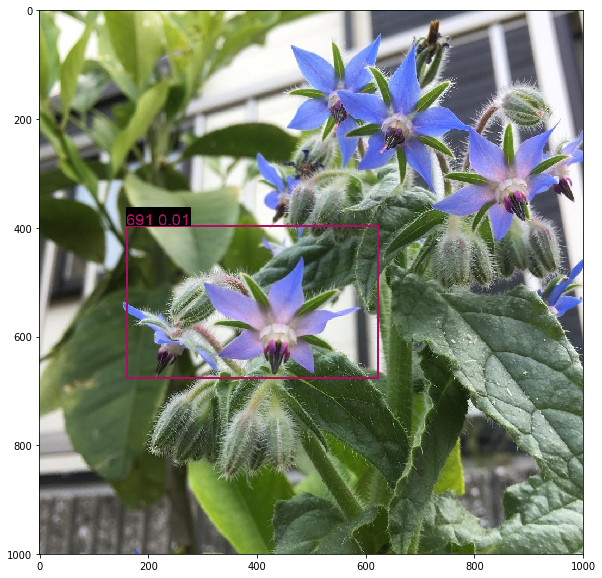

In [18]:
from PIL import Image

with torch.no_grad():
    img_path = './data/VOC_FULL/1050_output/JPEGImages/2_gs_1004753.jpg'
    img = Image.open(img_path)
    boxes, scores, classes = model.predict(img_path, score_threshold=0.01, iou_threshold=0.2)
result_show(img, boxes, classes, scores,  ds.classes)